In [81]:
import json
import pandas as pd
import numpy as np

import joblib

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler, PowerTransformer, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor

import requests
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, boxcox_normmax, probplot

In [82]:
FORWARD_STEPS = 10

https://docs.uniswap.org/sdk/subgraph/subgraph-examples

In [83]:
def get_data(address):
    query = f"""
        {{token (id: "{address}"){{tokenDayData(first:1000, skip:2) {{ priceUSD date open close high low volume volumeUSD}} }} }}
        """
    r = requests.post(url, json={'query': query})
    json_data = json.loads(r.text)

    df_data = json_data['data']['token']['tokenDayData']
    df = pd.DataFrame(df_data)
    return df

In [84]:
test_address = "0x1f9840a85d5af5bf1d1762f925bdaddc4201f984"
initial_df = get_data(test_address)
initial_df_len = len(initial_df)

# EDA

In [85]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   priceUSD   561 non-null    object
 1   date       561 non-null    int64 
 2   open       561 non-null    object
 3   close      561 non-null    object
 4   high       561 non-null    object
 5   low        561 non-null    object
 6   volume     561 non-null    object
 7   volumeUSD  561 non-null    object
dtypes: int64(1), object(7)
memory usage: 35.2+ KB


In [86]:
columns = ['priceUSD', 'open', 'close', 'high', 'low', 'volume', 'volumeUSD']

for x in columns:
    initial_df[x] = initial_df[x].astype(float)

In [87]:
initial_df.describe()

,priceUSD,date,open,close,high,low,volume,volumeUSD
count,561.000000,5.610000e+02,561.000000,561.000000,561.000000,561.000000,5.610000e+02,5.610000e+02
mean,14.644547,1.644451e+09,14.712498,14.644547,15.336186,13.989928,5.407817e+05,7.604261e+06
std,8.668113,1.400466e+07,8.738493,8.668113,9.132454,8.287403,5.789074e+05,9.177449e+06
min,3.645075,1.620259e+09,3.654224,3.645075,3.904146,2.906710,1.949339e+04,2.057296e+05
25%,6.810463,1.632355e+09,6.862817,6.810463,7.086080,6.576226,2.075827e+05,2.118463e+06
50%,11.134227,1.644451e+09,11.206072,11.134227,11.660897,10.597077,4.094427e+05,4.347922e+06
75%,22.045277,1.656547e+09,22.090684,22.045277,23.236679,20.865919,6.640339e+05,9.276507e+06
max,40.572031,1.668643e+09,42.129562,40.572031,43.846977,39.770178,7.982269e+06,6.138762e+07


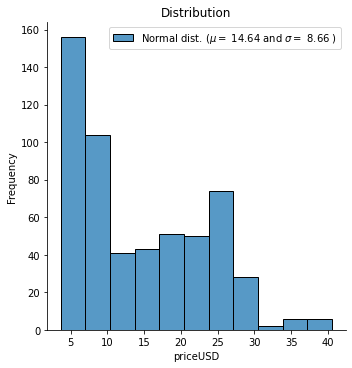

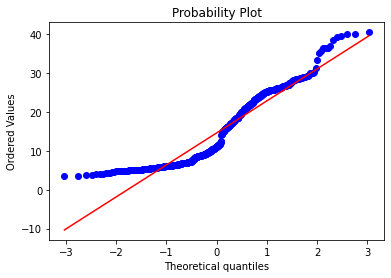

In [88]:
def plot_dist(var):
    sns.displot(var);
    (mu, sigma) = norm.fit(var)

    #plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution')

    #QQ-plot
    plt.figure()
    probplot(var, plot=plt)
    plt.show()

plot_dist(initial_df['priceUSD'])

## Target value Transformation

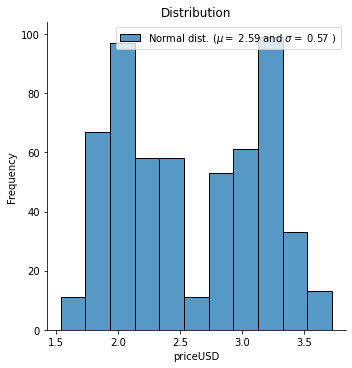

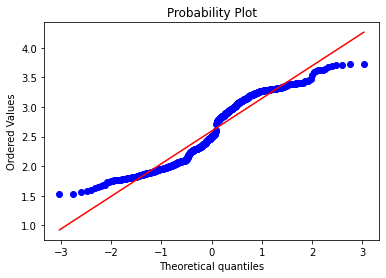

In [89]:
initial_df["priceUSD"] = np.log1p(initial_df["priceUSD"])
plot_dist(initial_df['priceUSD'])

## Features Skew Elimination

In [90]:
numeric_feats = initial_df.dtypes[(initial_df.dtypes != "object") & (initial_df.dtypes != 'category') & (initial_df.dtypes!= 'datetime64[ns]')].index.tolist()

skewed_feats = initial_df[numeric_feats].apply(lambda x: skew(x.dropna()))
print(skewed_feats)

priceUSD     0.072881
date         0.000000
open         0.660212
close        0.641710
high         0.673982
low          0.657644
volume       5.137327
volumeUSD    2.748430
dtype: float64


In [91]:
sk = skewed_feats[abs(skewed_feats)>1].index.to_list()
print(sk)

['volume', 'volumeUSD']


In [92]:
initial_df[sk] = np.log1p(initial_df[sk])

## Feature Engineering

In [93]:
def input_cells(latest_date, steps=15):
    empty_predictions = pd.DataFrame({'date':[n*86400+latest_date for n in range(1, steps+1)]})
    return empty_predictions

In [94]:
def time_features(df):
    df["utc"] = df.date.apply(lambda x: datetime.utcfromtimestamp(x))
    df['day'] = df.utc.apply(lambda time: time.day)
    df["weekday"] = df.utc.apply(lambda time: time.dayofweek)
    df['month'] = df.utc.apply(lambda time: time.month)
    df['year'] = df.utc.apply(lambda time: time.year).astype("category")
    return df

df = time_features(initial_df)

In [95]:
columns = ['open', 'close', 'high', 'low', 'volume', 'volumeUSD']

for x in columns:
    df[x] = df[x].shift(FORWARD_STEPS)

In [96]:
df

,priceUSD,date,open,close,high,low,volume,volumeUSD,utc,day,weekday,month,year
0,3.714674,1620259200,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-06,6,3,5,2021
1,3.705376,1620345600,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-07,7,4,5,2021
2,3.727428,1620432000,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-08,8,5,5,2021
3,3.697291,1620518400,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-09,9,6,5,2021
4,3.627269,1620604800,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-10,10,0,5,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,1.917428,1668297600,7.072934,6.920803,7.404688,6.918161,13.541586,15.516229,2022-11-13,13,6,11,2022
557,1.955355,1668384000,6.920761,7.541704,7.718019,6.838108,14.245108,16.239598,2022-11-14,14,0,11,2022
558,1.984157,1668470400,7.543823,7.687336,7.866911,7.543823,14.075278,16.114012,2022-11-15,15,1,11,2022
559,1.939570,1668556800,7.684777,7.092123,7.712900,7.065922,13.371307,15.387756,2022-11-16,16,2,11,2022


## Training

In [97]:
ceiling = int(len(df)*0.8)

In [98]:
train, test = df[10:ceiling], df[ceiling:]

In [99]:
df.columns

Index(['priceUSD', 'date', 'open', 'close', 'high', 'low', 'volume',
       'volumeUSD', 'utc', 'day', 'weekday', 'month', 'year'],
      dtype='object')

In [100]:
numeric_features = [
                    'weekday', 
                    'day', 
                    'month', 
                    'open', 
                    'close', 
                    'high', 
                    'low', 
                    'volume', 
                    'volumeUSD', 
                    'priceUSD',
                    ]

object_features = [
    'year'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), object_features),
        ('num', RobustScaler() , numeric_features)
    ])

In [101]:
clf_xg = Pipeline(steps=[
                    ('pre', preprocessor),
                    ('poly', PolynomialFeatures(2)),
                    ('selection', SelectFromModel(estimator=RandomForestRegressor(n_estimators=150, random_state=1))),
                    ('a', MLPRegressor(random_state=1, max_iter=500, solver="adam", alpha=0.0001, early_stopping=False)),
                    ])

clf_xg.fit(train[numeric_features + object_features], train['priceUSD'])

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year']),
                                                 ('num', RobustScaler(),
                                                  ['weekday', 'day', 'month',
                                                   'open', 'close', 'high',
                                                   'low', 'volume', 'volumeUSD',
                                                   'priceUSD'])])),
                ('poly', PolynomialFeatures()),
                ('selection',
                 SelectFromModel(estimator=RandomForestRegressor(n_estimators=150,
                                                                 random_state=1))),
                ('a', MLPRegressor(max_iter=500, random_state=1))])

In [102]:
import joblib
model_filename = "model.pkl"
joblib.dump(clf_xg, model_filename)

['model.pkl']

In [103]:
predictions = clf_xg.predict(test[numeric_features + object_features])

In [104]:
mae = mean_absolute_error(np.expm1(test['priceUSD']), np.expm1(predictions), multioutput="raw_values")

In [105]:
mae

array([0.21230177])